## Importing Relevant news

In [14]:
# data analysis libs
import numpy as np
import pandas as pd
import gc

# visualizatioon libs
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning libs
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# tensorFlow & Keras
from tensorflow import keras as kr
from tqdm.keras import TqdmCallback

## Data loading and labeling

In [2]:
file = 'FakeNewsNet.csv'
df = pd.read_csv(file)
print(df.head())

                                               title  \
0  Kandi Burruss Explodes Over Rape Accusation on...   
1  People's Choice Awards 2018: The best red carp...   
2  Sophia Bush Sends Sweet Birthday Message to 'O...   
3  Colombian singer Maluma sparks rumours of inap...   
4  Gossip Girl 10 Years Later: How Upper East Sid...   

                                            news_url        source_domain  \
0  http://toofab.com/2017/05/08/real-housewives-a...           toofab.com   
1  https://www.today.com/style/see-people-s-choic...        www.today.com   
2  https://www.etonline.com/news/220806_sophia_bu...     www.etonline.com   
3  https://www.dailymail.co.uk/news/article-33655...  www.dailymail.co.uk   
4  https://www.zerchoo.com/entertainment/gossip-g...      www.zerchoo.com   

   tweet_num  real  
0         42     1  
1          0     1  
2         63     1  
3         20     1  
4         38     1  


In [3]:
columns = ['title','real']
df = pd.read_csv(file, usecols=columns)
print(df.head())

                                               title  real
0  Kandi Burruss Explodes Over Rape Accusation on...     1
1  People's Choice Awards 2018: The best red carp...     1
2  Sophia Bush Sends Sweet Birthday Message to 'O...     1
3  Colombian singer Maluma sparks rumours of inap...     1
4  Gossip Girl 10 Years Later: How Upper East Sid...     1


You can see from above that for real news you see that we get 1, for fake we get 0.

In [4]:
# drop NULLs (if any) & reset index
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# adding a new column [word count]
df['wcount'] = df['title'].apply(lambda x: len(x.split(' ')))

# view
print(f"After cleaning we have {df.shape[0]} news...")

After cleaning we have 23196 news...


## Data visualization

C:\Users\ruben\anaconda3\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


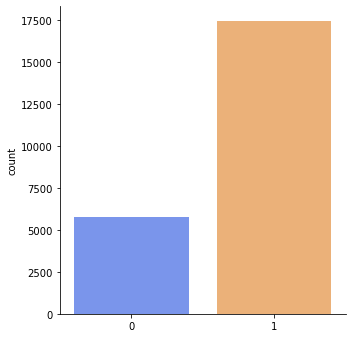

In [7]:
# True && False visualization - counting fake and real
count = []
for i in df['real'].unique():
    count.append(df[df['real'] == i].count()[1])
    
# Histogram counting barplot for fake&realnews
g = sns.catplot(
    data=df, kind="bar",
    x=df['real'].unique(), y=count,alpha=.6,
    palette="bright")

#g.despine(left=True)
g.set_axis_labels("", "count")

## Feature engineering

In [8]:
# feature engineering & training slipt
x = df['title'].values # feature
y = df['real'].values # target

# train & validation split [80-20]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state= np.random.randint(10))

# split visualization
print(f"Training records: {x_train.shape[0]} | Testing records: {x_test.shape[0]}")

Training records: 18556 | Testing records: 4640


## text pre-processing

In [9]:
tok = kr.preprocessing.text.Tokenizer(num_words=None,
                                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                                      lower=True,
                                      split=' ',
                                      char_level=False,
                                      oov_token=None)
# fit 
tok.fit_on_texts(x_train)

## text tokenizing

In [10]:
# tokenized text data
tok_train = tok.texts_to_sequences(x_train)
tok_test = tok.texts_to_sequences(x_test)

## Pad Sequences

In [11]:
# Padding the sequences for the training 
max_length = int(df.wcount.quantile(0.75))   # taking the 75th percentile of word count

padded_train = kr.preprocessing.sequence.pad_sequences(tok_train, maxlen=max_length, padding='post')
padded_test = kr.preprocessing.sequence.pad_sequences(tok_test, maxlen=max_length, padding='post')

## Simple Recursion Neural Network Model training (RNN)

In [12]:
# model params
vocab_size = len(tok.word_index) + 1
epoch = 10
unit = 32

# define model
model = kr.models.Sequential(name='FakeNewsCatcher')
model.add(kr.layers.Embedding(vocab_size, unit, input_length=max_length))
model.add(kr.layers.SimpleRNN(unit, return_sequences=False))
model.add(kr.layers.Dense(1, activation='sigmoid'))

# compile
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# summary
model.summary()

Model: "FakeNewsCatcher"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 14, 32)            700672    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 702,785
Trainable params: 702,785
Non-trainable params: 0
_________________________________________________________________


In [15]:
# training params
es = kr.callbacks.EarlyStopping(monitor='val_loss', mode='min',verbose=0, patience=5)

# for re-runs
gc.collect()
kr.backend.clear_session()

# train model
hist = model.fit(x=padded_train,
                 y=y_train,
                 epochs=epoch,
                 shuffle=True,
                 validation_data=(padded_test,y_test),
                 verbose=0,
                 callbacks=[TqdmCallback(verbose=0),es])

0epoch [00:00, ?epoch/s]

In [16]:
# accuracy
acc = '{:.2%}'.format(hist.history['accuracy'][-1])
print(f"Our model has achieved an accuracy of {acc} in {hist.epoch[-1]} epoch(s)")

Our model has achieved an accuracy of 97.09% in 6 epoch(s)


In [17]:
# predictions
pred = (model.predict(padded_test) > 0.5).astype('int32')

# classification report
print(classification_report(y_test, pred))

# accuracy score
acc_score = '{:.2%}'.format(accuracy_score(y_test, pred))
print(f"\nAccuracy Score: {acc_score}")

145/145 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

           0       0.51      0.63      0.56      1128
           1       0.87      0.81      0.84      3512

    accuracy                           0.76      4640
   macro avg       0.69      0.72      0.70      4640
weighted avg       0.78      0.76      0.77      4640


Accuracy Score: 76.42%


## Bi-directional RNN model training

In [18]:
model2 = kr.models.Sequential(name='FakeNewsCatcher2')
model2.add(kr.layers.Embedding(vocab_size, unit, input_length=max_length))
model2.add(kr.layers.Bidirectional(kr.layers.SimpleRNN(unit)))
model2.add(kr.layers.Dense(unit, activation='relu'))
model2.add(kr.layers.Dense(1, activation='sigmoid'))

# compile
model2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# summary
model2.summary()

Model: "FakeNewsCatcher2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 14, 32)            700672    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               4160      
 l)                                                              
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 706,945
Trainable params: 706,945
Non-trainable params: 0
_________________________________________________________________


In [19]:
# for re-runs
gc.collect()
kr.backend.clear_session()

# train model
hist2 = model2.fit(x=padded_train,
                 y=y_train,
                 epochs=epoch,
                 shuffle=True,
                 validation_data=(padded_test,y_test),
                 verbose=0,
                 callbacks=[TqdmCallback(verbose=0),es])

0epoch [00:00, ?epoch/s]

In [20]:
# accuracy
acc2 = '{:.2%}'.format(hist2.history['accuracy'][-1])
print(f"Our model has achieved an accuracy of {acc2} in {hist2.epoch[-1]} epoch(s)")

Our model has achieved an accuracy of 97.13% in 5 epoch(s)


In [21]:
# predictions
pred2 = (model2.predict(padded_test) > 0.5).astype('int32')

# classification report
print(classification_report(y_test, pred2))

# accuracy score
acc_score2 = '{:.2%}'.format(accuracy_score(y_test, pred2))
print(f"\nAccuracy Score: {acc_score2}")

145/145 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.50      0.62      0.55      1128
           1       0.87      0.80      0.83      3512

    accuracy                           0.76      4640
   macro avg       0.68      0.71      0.69      4640
weighted avg       0.78      0.76      0.76      4640


Accuracy Score: 75.56%
